This is a scratch notebook I used while developing the code and ideas in my parallel curve blog post, and the Euler spiral functions in kurbo.

Copyright 2021 The raphlinus.github.io Authors.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
%pylab inline
from scipy.misc import central_diff_weights


Populating the interactive namespace from numpy and matplotlib


The following code establishes preliminaries for Euler spirals. All the `integ_euler` functions follow the conventions of chapter 8.1 of my [thesis](https://www.levien.com/phd/thesis.pdf), but leaving out k2 and k3. In other words, it evaluates the following variant of the Fresnel integral (as expressed in complex form):

$$
\int_{-0.5}^{0.5} \exp(i(k_0 s + 1/2\, k_1 s^2)) \, ds
$$

This version has careful error bounds, with a section later in this notebook validating them.

In [2]:
def integ_euler_12(k0, k1):
  t1_1 = k0
  t1_2 = 0.5 * k1
  t2_2 = t1_1 * t1_1
  t2_3 = 2. * (t1_1 * t1_2)
  t2_4 = t1_2 * t1_2
  t3_4 = t2_2 * t1_2 + t2_3 * t1_1
  t3_6 = t2_4 * t1_2
  t4_4 = t2_2 * t2_2
  t4_5 = 2. * (t2_2 * t2_3)
  t4_6 = 2. * (t2_2 * t2_4) + t2_3 * t2_3
  t4_7 = 2. * (t2_3 * t2_4)
  t4_8 = t2_4 * t2_4
  t5_6 = t4_4 * t1_2 + t4_5 * t1_1
  t5_8 = t4_6 * t1_2 + t4_7 * t1_1
  t5_10 = t4_8 * t1_2
  t6_6 = t4_4 * t2_2
  t6_7 = t4_4 * t2_3 + t4_5 * t2_2
  t6_8 = t4_4 * t2_4 + t4_5 * t2_3 + t4_6 * t2_2
  t6_9 = t4_5 * t2_4 + t4_6 * t2_3 + t4_7 * t2_2
  t6_10 = t4_6 * t2_4 + t4_7 * t2_3 + t4_8 * t2_2
  t7_8 = t6_6 * t1_2 + t6_7 * t1_1
  t7_10 = t6_8 * t1_2 + t6_9 * t1_1
  t8_8 = t6_6 * t2_2
  t8_9 = t6_6 * t2_3 + t6_7 * t2_2
  t8_10 = t6_6 * t2_4 + t6_7 * t2_3 + t6_8 * t2_2
  t9_10 = t8_8 * t1_2 + t8_9 * t1_1
  t10_10 = t8_8 * t2_2
  u = 1.
  u -= (1./24.) * t2_2 + (1./160.) * t2_4
  u += (1./1920.) * t4_4 + (1./10752.) * t4_6 + (1./55296.) * t4_8
  u -= (1./322560.) * t6_6 + (1./1658880.) * t6_8 + (1./8110080.) * t6_10
  u += (1./92897280.) * t8_8 + (1./454164480.) * t8_10
  u -= 2.4464949595157930e-11 * t10_10
  v = (1./12.) * t1_2
  v -= (1./480.) * t3_4 + (1./2688.) * t3_6
  v += (1./53760.) * t5_6 + (1./276480.) * t5_8 + (1./1351680.) * t5_10
  v -= (1./11612160.) * t7_8 + (1./56770560.) * t7_10
  v += 2.4464949595157932e-10 * t9_10
  return (u, v)

def integ_euler_12n(k0, k1, n):
  th1 = k0
  th2 = 0.5 * k1
  ds =  1.0 / n

  k0 *= ds
  k1 *= ds

  x = 0.0
  y = 0.0
  s = 0.5 * ds - 0.5

  for i in range(n):
    km0 = k1 * s + k0
    km1 = k1 * ds

    (u, v) = integ_euler_12(km0, km1)

    th = (th2 * s + th1) * s
    cth = cos(th)
    sth = sin(th)

    x += cth * u - sth * v
    y += cth * v + sth * u
    s += ds
  return (x * ds, y * ds)

def integ_euler(k0, k1, accuracy = 1e-9):
  k0max = abs(k0) + 0.5 * abs(k1)
  est_err_raw = 0.006 * k0max ** 2 + 0.029 * abs(k1)
  est_err = est_err_raw ** 6
  if est_err < accuracy:
    return integ_euler_12(k0, k1)
  else:
    if isnan(est_err_raw / accuracy ** (1./6)):
      print(k0, k1, accuracy)
    n = int(ceil(est_err_raw / accuracy ** (1./6)))
    return integ_euler_12n(k0, k1, n)

integ_euler(1, 0)

(0.9588510772083668, 0.0)

This is an implementation of section 8.2 of the thesis. The secant method converges quadratically, so even ridiculously small error bounds are cheap to compute. The precision is misleading though, unless the `integ_euler` logic above were recalibrated with corresponding accuracy.

Also note that the initial calculation of `k1` is approximated using 3rd order polynomials, as opposed to the 1st order approximation in the thesis. The next passage will be trying to develop a 2D Taylor's series from numerical evaluation, using this function as the source of truth.

In [3]:
def fit_euler(th0, th1):
    k1_old = 0.0
    dth = th1 - th0
    k0 = th0 + th1
    k1 = (6.0 - (1./70.) * dth * dth - 0.1 * k0 * k0) * dth
    error_old = dth
    for i in range(10):
        (u, v) = integ_euler(k0, k1, 1e-15)
        chth = arctan2(v, u)
        error = dth - (0.25 * k1 - 2.0 * chth)
        if abs(error) < 5e-15:
            chord = hypot(u, v)
            return (k0, k1, chord, chth)
        new_k1 = k1 + (k1_old - k1) * error / (error - error_old)
        k1_old = k1
        error_old = error
        k1 = new_k1

fit_euler(0.01, -0.01)

(0.0, -0.11999988571398887, 0.9999900000547617, -0.004999985714248608)

The basic approach I use here is [central difference](https://en.wikipedia.org/wiki/Finite_difference), generalized to 2 dimensions. This is okay, but it feels like it's possible to do better. In particular, I think the accuracy of the higher order coefficients is not great. To do better, I'd explore Chebyshev techniques. Unfortunately, while NumPy has pretty good infrastructure for Chebyshev in 1D, it's lacking 2D. Obviously [chebfun](https://www.chebfun.org/) would be a much richer infrastructure, but would require switching to Matlab.

In [4]:
def est_derivs(f, nx, ny, delta):
  width = 11
  for j in range(ny):
    jwts = central_diff_weights(width, ndiv = j)
    for i in range(nx):
      sum = 0
      wts = central_diff_weights(width, ndiv = i)
      for y, cy in enumerate(jwts):
        yy = delta * (y - 0.5 * (width - 1))
        for x, cx in enumerate(wts):
          xx = delta * (x - 0.5 * (width - 1))
          sum += cx * cy * f(xx, yy)
        #print('->', cx, xx)
      sum /= delta ** (i + j)
      print(i, j, sum)

#est_derivs(lambda x, y: fit_euler(0.5 * (y - x), 0.5 * (x + y))[1], 8, 8, .1)

Here's the same basic algorithm, but adapted to generate code to evaluate the Taylor's series that results from the derivatives. Zero coefficients are suppressed, and it also evaluates a triangle rather than a square, so the total order is bounded.

In [22]:
def fmt_coeff(base, exponent):
  if exponent == 0:
    return ''
  elif exponent == 1:
    return base + ' * '
  else:
    return '{} ** {} * '.format(base, exponent)

def round_recip(x):
  x_recip = 1 / x
  if abs(x) > 0.5 and abs(round(x) - x) < 1e-9:
    return '{}'.format(round(x))
  if abs(round(x_recip) - x_recip) < 0.01:
    return '(1. / {}.)'.format(round(x_recip))
  else:
    return '{}'.format(x)

def est_coeffs(f, n, delta):
  width = 11
  for j in range(n + 1):
    jwts = central_diff_weights(width, ndiv = j)
    for i in range(n - j + 1):
      sum = 0
      wts = central_diff_weights(width, ndiv = i)
      for y, cy in enumerate(jwts):
        yy = delta * (y - 0.5 * (width - 1))
        for x, cx in enumerate(wts):
          xx = delta * (x - 0.5 * (width - 1))
          sum += cx * cy * f(xx, yy)
        #print('->', cx, xx)
      sum /= delta ** (i + j)
      sum /= math.factorial(i) * math.factorial(j)
      if abs(sum) > 1e-9:
        #print(i, j, sum, 1/sum)
        print('  est += {}{}{}'.format(fmt_coeff('dth', i), fmt_coeff('k0', j), round_recip(sum)))

est_coeffs(lambda x, y: 1/fit_euler(0.5 * (y - x), 0.5 * (x + y))[2], 7, .1)

  est += 1
  est += dth ** 2 * (1. / 40.)
  est += dth ** 4 * 0.00028273809628225814
  est += dth ** 6 * 4.4684406637814534e-07
  est += k0 ** 2 * (1. / 24.)
  est += dth ** 2 * k0 ** 2 * -0.0003869047534246003
  est += dth ** 4 * k0 ** 2 * -3.6611750357952e-05
  est += k0 ** 4 * 0.001215277778091484
  est += dth ** 2 * k0 ** 4 * -5.295182630050706e-05
  est += k0 ** 6 * 3.203536970805244e-05


And here are functions based on `est_coeffs` above, usually going up to 7th order polynomials, and in some cases with hand tuning. I believe (without any kind of proof) that the coefficients are reciprocals of integers, which is pretty clear for many of the lower order terms (and I've tweaked the formatting code to round to the reciprocal), but accuracy degrades beyond that. If we could calculate the derivates more accurately and this hypothesis is true, we should be able to get the exact values by rounding the reciprocals.

In theory it should be possible to get exact values analytically as well (as is done in the thesis to the first order), but that seems challenging.

In [6]:
def est_k1(th0, th1):
  k0 = th0 + th1
  dth = th1 - th0
  est = dth * 6
  est += dth ** 3 * (1. / -70.)
  est += dth ** 5 * (1. / -10780.)
  est += dth ** 7 * 2.769178184818219e-07
  est += dth * k0 ** 2 * (1. / -10.)
  est += dth ** 3 * k0 ** 2 * (1. / 4200.)
  est += dth ** 5 * k0 ** 2 * 1.6959677820260655e-05
  est += dth * k0 ** 4 * (1. / -1400.)
  est += dth ** 3 * k0 ** 4 * 6.84915970574303e-05
  est += dth * k0 ** 6 * -7.936475029053326e-06
  return est

def e(th0, th1):
  return fit_euler(th0, th1)[1] - est_k1(th0, th1)

e(0.6, -0.6)

-7.603220364416075e-08

The other values from `fit_euler` can also be approximated using a 2D Taylor's series. It's *probably* a win to compute these directly rather than hitting `integ_euler` after getting a value for k1, but likely not a huge win, as the latter should be pretty cheap.

Again the low order coefficients are reciprocals of integers.

Note that if k1 = 0, this is equal to sinc(k1/2), which certainly predicts the coefficients for the terms involving k0 only.

In [7]:
def est_ch(th0, th1):
  k0 = th0 + th1
  dth = th1 - th0
  est = 1
  est += dth ** 2 * (1. / -40.)
  est += dth ** 4 * 0.00034226190482569864
  est += dth ** 6 * -1.9349474568904524e-06
  est += k0 ** 2 * (1. / -24.)
  est += dth ** 2 * k0 ** 2 * 0.0024702380951963226
  est += dth ** 4 * k0 ** 2 * -3.7297408997537985e-05
  est += k0 ** 4 * (1. / 1920.)
  est += dth ** 2 * k0 ** 4 * -4.87350869747975e-05
  est += k0 ** 6 * -3.1001936068463107e-06
  return est

def e_ch(th0, th1):
  return fit_euler(th0, th1)[2] - est_ch(th0, th1)

e_ch(0.6, -0.6)

5.405147440740166e-09

In [8]:
def est_chth(th0, th1):
  k0 = th0 + th1
  dth = th1 - th0
  return 0.125 * est_k1(th0, th1) - 0.5 * dth

def e_chth(th0, th1):
  return fit_euler(th0, th1)[3] - est_chth(th0, th1)

e_chth(0.9, -0.9)

-3.6938566355670943e-07

Here we introduce an Euler spiral segment and code to approximate its parallel curve.

It's worth discussing the error metric. It's basically the L2 norm of the distance error between the two curves when evaluated with arclength parametrization. It's expected to correlate strongly with Hausdorff distance, but be more tractable to evaluate. The points are evenly sampled (by arclength) on the Euler spiral, and the exact arclength parametrization from the Wieleitner paper (attributed to Cesàro).

In [9]:
class Point:
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __repr__(self):
    return 'Point({}, {})'.format(self.x, self.y)

  def __sub__(self, other):
    return Point(self.x - other.x, self.y - other.y)

  def __add__(self, other):
    return Point(self.x + other.x, self.y + other.y)

  def __rmul__(self, other):
    return Point(other * self.x, other * self.y)

  def hypot2(self):
    return self.x ** 2 + self.y ** 2

  def hypot(self):
    return hypot(self.x, self.y)

  @staticmethod
  def from_angle(th):
    return Point(cos(th), sin(th))

class ApproxResult:
  def __init__(self, seg, dth):
    self.seg = seg
    self.dth = dth

class EulerSeg:
  # th0 and th1 are deflections relative to the chord
  def __init__(self, p0, p1, th0, th1):
    self.params = fit_euler(th0, th1)
    self.p0 = p0
    self.p1 = p1

  def arclen(self):
    return hypot(self.p0.y - self.p1.y, self.p0.x - self.p1.x) / self.params[2]

  # return theta relative to chord.
  # Sign is confusing (= -th0 at t = 0, th1 at t = 1), but matches spiro code
  def th(self, t):
    u = t - 0.5
    return (0.5 * self.params[1] * u + self.params[0]) * u - self.params[3]

  def eval(self, t):
    thm = self.th(t * 0.5)
    k0 = self.params[0]
    k1 = self.params[1]
    u, v = integ_euler((k0 + k1 * 0.5 * (t - 1.0)) * t, k1 * t * t)
    s = t / self.params[2] * sin(thm)
    c = t / self.params[2] * cos(thm)
    x = u * c - v * s
    y = -v * c - u * s
    xx = self.p0.x + (self.p1.x - self.p0.x) * x - (self.p1.y - self.p0.y) * y
    yy = self.p0.y + (self.p1.x - self.p0.x) * y + (self.p1.y - self.p0.y) * x
    return Point(xx, yy)

  # return the actual signed curvature
  def curvature(self, t):
    k = self.params[0] + self.params[1] * (t - 0.5)
    return k / self.arclen()

  # Approximate a parallel curve
  def approx_parallel(self, offset):
    chord_scale = offset / hypot(self.p1.y - self.p0.y, self.p1.x - self.p0.x)
    x0 = chord_scale * sin(self.th(0))
    y0 = chord_scale * cos(self.th(0))
    x1 = chord_scale * sin(self.th(1))
    y1 = chord_scale * cos(self.th(1))
    dth = arctan2(y1 - y0, 1 + x1 - x0)
    p0 = Point(self.p0.x + x0, self.p0.y + y0)
    p1 = Point(self.p1.x + x1, self.p1.y + y1)
    seg = EulerSeg(p0, p1, -self.th(0) - dth, self.th(1) + dth)
    return ApproxResult(seg, dth)

  # assume 0,0 - 1,0 chord in source for simplicity
  def approx_parallel_err(self, offset, n = 10):
    approx = self.approx_parallel(offset)
    sum = 0
    pts = []
    pts2 = []
    t_scale = offset * self.params[2]
    t0 = t_scale * self.th(0)
    t1 = 1 + t_scale * self.th(1)
    for i in range(-1, n + 1):
      # parameter at base
      t = (i + 1.0) / (n + 1.0)
      base = self.eval(t)
      th = self.th(t)
      actual = Point(base.x + offset * sin(th), base.y + offset * cos(th))
      pts.append(actual)
      t_mapped = (t + t_scale * th - t0) / (t1 - t0)
      pts2.append(approx.seg.eval(t_mapped))
      sum += (actual - approx.seg.eval(t_mapped)).hypot2()
    sum = sqrt(sum / (n + 1.0))
    return (sum, pts, pts2)

  def est_err2(self, offset):
    chord_scale = offset / hypot(self.p1.y - self.p0.y, self.p1.x - self.p0.x)
    x0 = chord_scale * sin(self.th(0))
    y0 = chord_scale * cos(self.th(0))
    x1 = chord_scale * sin(self.th(1))
    y1 = chord_scale * cos(self.th(1))
    return hypot(x0 + x1, y0 - y1)

def est_err(th0, th1, offset):
  return 0.179284 * (th0 - th1) ** 2 * offset




I kept this image partly because it's pretty. It's a series of approximations of parallel curves from the original Euler spiral, each of which is an Euler spiral determined from geometric (G1) Hermite interpolation. Obviously as the offset increases, the true parallel curve gets a cusp, but the Euler spirals don't reflect that.

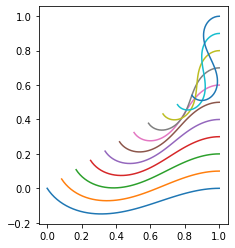

In [10]:
es = EulerSeg(Point(0, 0), Point(1, 0), -1, -0)
def plot_es(es):
  pts = [es.eval(t) for t in linspace(0, 1, 50)]
  plt.plot([p.x for p in pts], [p.y for p in pts])
plt.axes().set_aspect('equal')
plot_es(es)
for i in range(10):
  plot_es(es.approx_parallel(0.1 * (i + 1)).seg)

Here's a plot of an Euler spiral segment approximation and a true parallel curve, very close to a cusp.

(0.006719802334824395, 0.0063379668234947876)

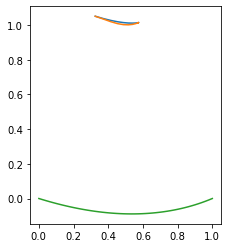

In [11]:
a = -0.3
b = a - 0.1
offset = 1.1
seg = EulerSeg(Point(0, 0), Point(1, 0), a, b)
approx = seg.approx_parallel(offset)
err, pts, pts2 = seg.approx_parallel_err(offset)
plt.axes().set_aspect('equal')
plt.plot([p.x for p in pts], [p.y for p in pts])
plt.plot([p.x for p in pts2], [p.y for p in pts2])
plot_es(seg)
#plot_es(approx.seg)
#(err, est_err(a, b, offset))

# The following estimate works ok when k0 is large wrt
# k1, but nulls out when k0 = 0
#(err, 0.02935 * approx.dth)

(err, seg.approx_parallel_err(offset, n = 1)[0])

#(err, 0.04 * seg.est_err2(offset))

This plot is strong empirical evidence that error scales as the reciprocal of the distance of the *midpoint* to the cusp.

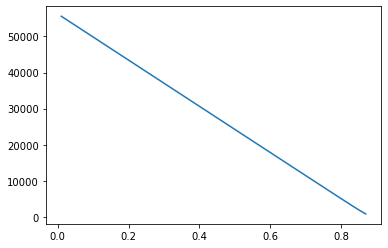

In [12]:
a = -0.6
b = a - 0.01
es = EulerSeg(Point(0, 0), Point(1, 0), a, b)
xs = []
ys = []
for x in linspace(0.01, 0.87):
  xs.append(x)
  err, pts, pts2 = es.approx_parallel_err(x)
  y = x/err
  ys.append(abs(y))
plt.plot(xs, ys)


In [13]:
2/(es.curvature(0) + es.curvature(1))
ctr = 1/(es.params[0] * es.params[2])
ctr

-0.8791042224513504

And here's a simple analytical formula for estimating the error of approximating the parallel curve of an Euler spiral with another Euler spiral. It's worked out empirically, but predicts the measured error well.

In [14]:
a = -0.3
b = a - 0.1
offset = 1.0
es = EulerSeg(Point(0, 0), Point(1, 0), a, b)
# This is a pretty good estimate.
def new_est_err(es, offset):
  radius = 1/(es.params[0] * es.params[2])
  return 0.00499 * abs(offset * radius / (offset + radius) * es.params[1] ** 2 / es.params[2])
#new_est_err(es, offset) / es.approx_parallel_err(offset)[0], es.params

# Algebraic reformulation, probably easier to work with
def new_est_err_2(es, offset):
  k0 = es.params[0] * es.params[2]
  return 0.00499 * abs(1 / (k0 + 1/offset) * es.params[1] ** 2) / es.params[2]
new_est_err_2(es, offset), new_est_err(es, offset)


(0.0057385348684406345, 0.005738534868440635)

This is some somewhat tricky logic for analytically determining the subdivisions for approximating an Euler spiral parallel curve. Basically, the goals are: all errors should be under the given threshold, and within that constraint, the number of subdivisions should be minimal. That implies that the error of each subdivision is equal.

The fundamental insight here is that if the subdivision points (as measured on the source curve) are chosen as $s = s_0 + (i \cdot \Delta s)^\frac{4}{3}$, where $s_0$ is the location of the cusp, then errors will be approximately equal. In fact, the error is *slightly* lower just near the cusp, 

In [15]:
# Here c, is min s / max s, where s is distance from cusp
def predict_rel(c):
  return (4./3. * (1 - (1 - c) ** .75) / c) ** 4 * (1 - .5 * c)
def spl(t0, t1, n = 10):
  c0 = t0 ** 0.75
  dt = (t1 ** 0.75 - c0) / n
  return [((c0 + i * dt) ** (4./3.) - t0) / (t1 - t0) for i in range(n+1)]
def subdiv(es, offset, thresh):
  e = new_est_err_2(es, offset)
  k0 = es.params[0] * es.params[2]
  t0 = abs(k0 + 1/offset) - 0.5 * abs(es.params[1] * es.params[2])
  t1 = abs(k0 + 1/offset) + 0.5 * abs(es.params[1] * es.params[2])
  if t0 < 0:
    print('cusp at', -t0 / (t1 - t0))
    t0 = 0
  print(t0, t1)
  p = predict_rel(1 - t0/t1)
  print(e, p, thresh)
  n = int(ceil((e * p / thresh) ** 0.25))
  # Note: split assumes cusp is at s < 0 etc; check signs of t0, t1
  return spl(t0, t1, n)

subdiv(es, offset, 1e-4)

0.02294503683788801 0.6057969056078494
0.0057385348684406345 1.3366077583140041 0.0001


[5.952536378197542e-18,
 0.25736795635726306,
 0.6008390258216808,
 1.0000000000000004]

This is an experiment in rendering an Euler spiral parallel curve to a cubic Bézier. It's promising, but the choice of control arm lengths feels a bit hacky and heuristic, and it's not clear to me yet how accuracy scales.

It's interesting to note that a cubic Bézier *can* approximate the cusp in an ESPC pretty well, because it can represent an exact [semicubical parabola](https://en.wikipedia.org/wiki/Semicubical_parabola), but that's not especially helpful as you get farther from the cusp.

In any case, the best accuracy scaling you can expect from a direct approach (based on the parabola method for ES control arms, as described in the blog post) is $n^5$ in the zero offset case. I think whether this method is worth pursuing depends on the goals. If the goal is a minimum number of subdivisions into cubic Béziers, then probably the best approach is to do real optimized curve fitting, for which a piecewise Euler spiral representation is likely most efficient. I'll leave this here as possible future work.

0.05318579874202456 5.838220834072745 (-0.3999999999999999, 6.726220666841354, 0.962606922066669, 0.2770390658155192)
0.5090276910179282 1.4909723089820717


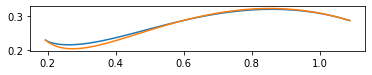

In [16]:
def offset_to_cubic(es, offset):
  k0 = es.params[0] * es.params[2]
  t0 = k0 + 1/offset - 0.5 * es.params[1] * es.params[2]
  t1 = k0 + 1/offset + 0.5 * es.params[1] * es.params[2]
  es2 = es.approx_parallel(offset)
  d = es2.seg.p1 - es2.seg.p0
  print(t0, t1, es2.seg.params)
  th0 = -es2.seg.th(0)
  th1 = es2.seg.th(1)
  c0, s0 = cos(th0), sin(th0)
  c1, s1 = cos(th1), sin(th1)
  r0 = 0.5 + t0 / (t0 + t1)
  r1 = 0.5 + t1 / (t0 + t1)
  print(r0, r1)
  l0 = 2.0 * r0 / (3.0 * (1 + c0))
  l1 = 2.0 * r1 / (3.0 * (1 + c1))
  d0 = l0 * Point.from_angle(th0)
  d1 = -l1 * Point.from_angle(-th1)
  p1 = es2.seg.p0 + Point(d.x * d0.x - d.y * d0.y, d.x * d0.y + d.y * d0.x)
  p2 = es2.seg.p1 + Point(d.x * d1.x - d.y * d1.y, d.x * d1.y + d.y * d1.x)
  return (es2.seg.p0, p1, p2, es2.seg.p1)

# Should be a class, ah well
def eval_cubic(cubic, t):
  p0, p1, p2, p3 = cubic
  mt = 1 - t
  return mt ** 3 * p0 + 3 * mt * t * (mt * p1 + t * p2) + t ** 3 * p3

def plot_cubic(cubic):
  pts = [eval_cubic(cubic, t) for t in linspace(0, 1, 50)]
  plt.plot([p.x for p in pts], [p.y for p in pts])

seg = EulerSeg(Point(0, 0), Point(1, 0), -0.7, 0.3)
offset = 0.3
err, pts, pts2 = seg.approx_parallel_err(offset, 50)
plt.axes().set_aspect('equal')
plt.plot([p.x for p in pts], [p.y for p in pts])
plot_cubic(offset_to_cubic(seg, offset))
#plt.plot([p.x for p in pts2], [p.y for p in pts2])
#plot_es(seg)


Following few cells are to establish rigorous error bounds on the Euler integration code.

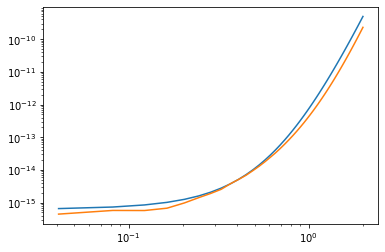

In [17]:
def est_integ_euler_err(k0, k1, n = 1):
  k0max = abs(k0) + 0.5 * abs(k1)
  est_err_raw = 0.006 * k0max ** 2 + 0.029 * abs(k1)
  return n ** -12 * est_err_raw ** 6

def actual_integ_euler_err(k0, k1, n = 1):
  actual = integ_euler_12n(k0, k1, 8)
  approx = integ_euler_12n(k0, k1, n)
  err = hypot(actual[0] - approx[0], actual[1] - approx[1])
  return err

xs = list(linspace(0, 2))[1:]
k1 = 0.1
n = 1
ys1 = []
ys2 = []
for k0 in xs:
  ys1.append(est_integ_euler_err(k0, k1, n))
  ys2.append(actual_integ_euler_err(k0, k1, n))
plt.plot(xs, ys1)
plt.plot(xs, ys2)
plt.xscale('log')
plt.yscale('log')

In [18]:
def check(th0, th1):
  es = fit_euler(th0, th1)
  return (es[1], es[1] / 8 - 0.5 * (th1 - th0), es[3])
check(0.1, 2)

(10.452623649390132, 0.35657795617376653, 0.356577956173766)

In [19]:
# Randomized testing to validate the error bound
n = 3
for i in range(1000):
  k0 = rand()
  k1 = 5 * rand()
  actual = actual_integ_euler_err(k0, k1)
  if actual > 1e-14:
    est = est_integ_euler_err(k0, k1)
    if est < actual:
      print(k0, k1, est, actual)

In [20]:
EulerSeg(Point(0, 0), Point(1, 0), 0.1, 0.2).params

(0.30000000000000004,
 0.5990851562066671,
 0.9960064696479229,
 0.024885644525833393)